# Macroeconomic forecasting

Taken from: https://blog.cambridgespark.com/macroeconomic-forecasting-345b48b7b12b

## Macroeconomic forecasting with Gaussian processes

In [37]:
#Install packages
#!pip install pandas
#!pip install statsmodels
#!pip3 install sklearn

### Configuration

In [56]:
# Forecasting years, number of years to use for out-of-sample 
# evaluation (We will create one forecast per country for each year
# which we compare to the actual GDP)
nyears = 10
# Number of lags to use for GP regression
lags = 5
# Indicator labels and names in the World Bank API
indicators  = {"gdp"        : "NY.GDP.MKTP.CD",
               "population" :    "SP.POP.TOTL",
               "inflation"  : "FP.CPI.TOTL.ZG"}
nindicators = len(indicators)
# The variable to forecast, should be one of the indicator labels
target_variable = "gdp"
# Countries to include in the data, specified as ISO country codes
countries  = ['au','ca','de','es','fr','gb','jp','us']
#countries  = ['au','ca','de','es','fr','gb','jp','us', "cl", "co"]
ncountries = len(countries)
# Start and end year for the data set
start_year = 1976
#end_year   = 2020
end_year   = 2014

### Data

In [57]:
import requests
import pandas as pd
template_url = "http://api.worldbank.org/v2/countries/{0}/indi"
template_url +="cators/{1}?date={2}:{3}&format=json&per_page=999"
# Countries should be ISO identifiers separated by semi-colon
country_str = ';'.join(countries)
raw_data = pd.DataFrame()
for label, indicator in indicators.items():
# Fill in the template URL
    url = template_url.format(country_str, indicator, 
                                  start_year, end_year)
    
    # Request the data
    json_data = requests.get(url)
    
    # Convert the JSON string to a Python object
    json_data = json_data.json()
    
    # The result is a list where the first element is meta-data, 
    # and the second element is the actual data
    json_data = json_data[1]
    
    # Loop over all data points, pick out the values and append 
    # them to the data frame
    for data_point in json_data:
        
        country = data_point['country']['id']
        
        # Create a variable for each country and indicator pair
        item    = country + '_' + label
        
        year    = data_point['date']
        
        value   = data_point['value']
        
        # Append to data frame
        new_row  = pd.DataFrame([[item, year, value]],
                                columns=['item', 'year', 'value'])
        raw_data = raw_data.append(new_row)
# Pivot the data to get unique years along the columns,
# and variables along the rows
raw_data = raw_data.pivot('year', 'item', 'value')
# Let's look at the first few rows and columns
print('\n', raw_data.iloc[:10, :5], '\n')


 item        AU_gdp  AU_inflation  AU_population        CA_gdp  CA_inflation
year                                                                       
1976  1.051015e+11     13.322884     14033000.0  2.065756e+11      7.541739
1977  1.103877e+11     12.309820     14192000.0  2.116122e+11      7.976445
1978  1.185360e+11      8.004926     14358000.0  2.186329e+11      8.973723
1979  1.349415e+11      9.122007     14514000.0  2.430721e+11      9.144677
1980  1.500323e+11     10.135841     14692000.0  2.738538e+11     10.129221
1981  1.769534e+11      9.487666     14927000.0  3.062149e+11     12.471612
1982  1.941046e+11     11.351820     15178000.0  3.135065e+11     10.768972
1983  1.773336e+11     10.038911     15369000.0  3.405477e+11      5.863588
1984  1.935936e+11      3.960396     15544000.0  3.553726e+11      4.304778
1985  1.805738e+11      6.734694     15758000.0  3.647565e+11      3.962031 



### Exploration

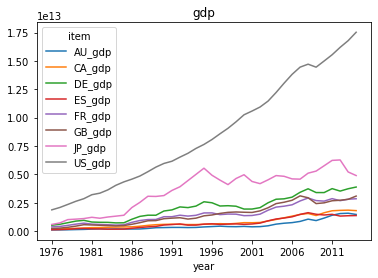

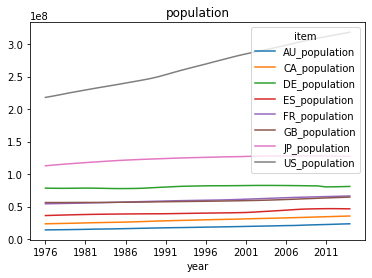

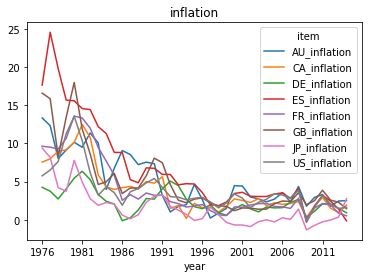

In [58]:
import matplotlib.pyplot as plt
for lab in indicators.keys():
    
    indicator = raw_data[[x for x in raw_data.columns 
                              if x.split("_")[-1] == lab]]
    indicator.plot(title=lab)
    plt.show()

### Transformation

In [59]:
import numpy as np
# Calculate rates of change instead of absolute levels
# (Runtime warning expected due to NaN)
data = np.log(raw_data).diff().iloc[1:,:]
# Set NaN to zero
data.fillna(0, inplace=True)
# Subtract the mean from each series
data = data - data.mean()
# Convert to date type
data.index = pd.to_datetime(data.index, format='%Y')
# Put the target variable into a separate data frame
target = data[[x for x in data.columns 
                   if x.split("_")[-1] == target_variable]]

### Evaluation
All models are evaluated in the same way. For each of the forecasting years (the last years of data) we train the model using the previous years and create a forecast for each country. For each forecast we calculate the squared error versus the true value, and then calculate the mean over countries and years, before taking the square root to arrive at a root mean squared error (RMSE). In other words
$$
RMSE = \sqrt{ \frac{1}{m}\sum_{i=1}^{m} (\hat{y_{i}} - y_{i})^2}
$$

where $\hat{y_{i}}$ is a forecast, $y_{i}$ is an actual value of the target variable and mm is the number of forecasts we create (the number of forecasting years times the number of countries).

### Baseline forecasts
We will first establish the performance of a simple baseline method, which will be used as a comparison to subsequent methods. Our baseline method will simply predict the same rate of change as the previous observation of the target variable.
Only if a more complicated method significantly outperforms a naive baseline forecast should it be preferred, in keeping with both the principle of Occam’s Razor, and the KISS principle in software development.

In [60]:
errors = target.iloc[-nyears:] - target.shift().iloc[-nyears:]
# Root mean squared error
rmse = errors.pow(2).sum().sum()/(nyears*ncountries)**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1063 |
	------------------



### Multivariate time series
We investigate the performance of a multivariate time series regression, also termed a Vector Autoregression (VAR) in econometrics. The model takes the form

$$
y_{t} = \sum_{i=1}^{d} \sum_{i=1}^{p} \beta_{ij} x_{i, t-j} + \varepsilon_{t}
$$

where 𝑑 is the number of independent variables, 𝜀 is the number of lags, εtεt is an error term and the $\beta_{i},j\beta_{i},j$ are parameters to be estimated.
To read more about time series analysis, a good introductory book is “Introduction to Time Series and Forecasting” by Brockwell and Davis, and two more advanced books are “Time Series: Theory and Methods”, also by Brockwell and Davis, and “Time Series Analysis” by Hamilton.
To fit the model we use the ```statsmodels``` package, whose ```VAR``` implementation uses least squares to estimate the parameters. We train the model using one lag, i.e. regressing the target variable on the most recent previous values of the independent variables, but automatic methods to choose the number of lags are also supported in the ```statsmodels``` package, such as the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

In [61]:
from statsmodels.tsa.api import VAR
# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Create a VAR model
    model = VAR(target.iloc[t:-nyears+t], freq='AS')
    
    # Estimate the model parameters
    results = model.fit(maxlags=1)
    
    actual_values = target.values[-nyears+t+1]
    
    forecasts = results.forecast(target.values[:-nyears+t], 1)
    forecasts = forecasts[0,:ncountries]
sse += ((actual_values - forecasts)**2).sum()
# Root mean squared error
rmse = (sse / (nyears * ncountries))**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.0282 |
	------------------



We see that the error is about the same as the baseline model, which argues against using the more complicated VAR model for macroeconomic forecasting with the current data.

## Gaussian process regression
We will now attempt to forecast GDP using Gaussian process regression. Our model is similar to before, and is given by
$$
y_{t} = f(x_{t}) + \varepsilon_{t} \; \; t=1,2,...,n
$$
where the $y_{t}$ are observations of the target variable, each $x_{t}$ is a vector of observations of an independent (predictor) variable, $f(x)$ is the regression function and the noise term $\varepsilon_{t}$ has a normal (Gaussian) distribution with variance $\alpha$. For each out-of-sample forecast, we will put the $n\times n$ previous observations of the target variable $y$ into a column vector which we will denote $y$. We will also let $X$ denote the matrix of the $n\times n$  previous observations of the predictor variable, where each observation occupies a row in the matrix. Here each observation will include lagged values of our variables from before (countries and indicators)

Instead of the regression function $f(x)$ being a linear function with unknown parameters, the function is now random, such that its value at each point $x_{t}$ is a normally distributed random variable, and such that the covariance between two random variables $f(x_{t})$ and $f(x_{s})$ is given by a so-called covariance function (or kernel) $k(x_{t}, x_{s})$, which needs to be specified. The function $f(x_{t})$ is called a Gaussian process. Since the error term is normally distributed the target values will also be normally distributed, with covariance equal to  $k(x_{t}, x_{s}) + a$ if $t = s$ and $k(x_{t}, x_{s})$ otherwise.


Suppose we want to estimate the model using nn data points for $y_{t}$ and $x_{t}$ and that we have a new test point $f(x_{n+1})$, based on which we want to make a forecast $\hat{y_{n+1}}$. The conditional distribution of $f(x_{n+1})$ given $y, X \; \text{and} \; x_{n+1}$ is then also normally distributed and we can ta ke our forecast $\hat{y_{n+1}}$ to be the conditional expected value of $f(x_{n+1})$. By a well-known formula for the multivariate Gaussian distribution it is given by

$$
E[f(x_{n+1})| {\bf{y}}, X, x_{n+1}] = {\bf{y}}^T (\alpha I + K)^{-1} {\bf{k}}
$$

where $K$ is an $n×n$ matrix where the entry on row $t$ and column $s$ is given by $k(x_{s},x_{t})$, $I$ is the identity matrix, and ${\bf{k}}$ is a length-$n$ column vector with entry $t$ given by $k(x_{t},x_{n+1})$

To read more about Gaussian process methods, which can also be used for classification, see for example the book “Gaussian Processes in Machine Learning” by Rasmussen and Williams.

To implement Gaussian process regression we make use of ready-made functionality in the ```scikit-learn package``` (see this link for documentation). For each forecasting year we create the vector 𝘺 of past observations of the target variable, and the data matrix 𝑋 of observations of the independent variable. We feed these into the ```GaussianProcessRegressor``` class to estimate the model, and then make a forecast for the following year. Like before, we calculate the error of a number of forecasts which we sum into a root mean squared error.
We will use the common Gaussian covariance function, which is given by

$$
k(x_{t}, x_{s}) = e^{||x_{t}-x_{s}||^{2}/\sigma^2}
$$
where $||V||$ is the length of the vector $vv$, and $\sigma\sigma$ is a parameter.

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# We set the parameter of the covariance function to
# approximately equal to the median distance between data points,
# a common heuristic for this covariance function. The 'alpha' 
# argument is the noise variance, which we set equal to the 
# covariance parameter.
gpr = GaussianProcessRegressor(kernel=RBF(0.1), alpha=0.1)
# Number of data points for estimation/fitting for each forecast
ndata = target.shape[0] - nyears - lags
# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Observations for the target variables
    y = np.zeros((ndata, ncountries))
# Observations for the independent variables
    X = np.zeros((ndata, lags*ncountries*nindicators))
    
    for i in range(ndata):
        
        y[i] = target.iloc[t+i+1]
        X[i] = data.iloc[t+i+2:t+i+2+lags].values.flatten()
        
    gpr.fit(X, y)
    
    x_test   = np.expand_dims(data.iloc[t+1:t+1+lags].values.flatten(), 0)
    forecast = gpr.predict(x_test)
    
    sse += ((target.iloc[t].values - forecast)**2).sum()
    
rmse = (sse / (nyears * ncountries))**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1206 |
	------------------



With Gaussian process regression we obtain the best results so far, with a slight improvement on the baseline and linear regression models.